# Neural Network

The dataset contains 36733 instances of 11 sensor measures aggregated over one hour (by means of average or sum) from a gas turbine. 
The Dataset includes gas turbine parameters (such as Turbine Inlet Temperature and Compressor Discharge pressure) in addition to the ambient variables.



Problem statement: predicting turbine energy yield (TEY) using ambient variables as features.




In [49]:
import warningsimport tensorflow as tf
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV,KFold
from keras.optimizers import adam_v2
from sklearn.preprocessing import StandardScaler

In [2]:
ft = pd.read_csv("forestfires.csv")
ft

,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,...,monthfeb,monthjan,monthjul,monthjun,monthmar,monthmay,monthnov,monthoct,monthsep,size_category
0,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,...,0,0,0,0,1,0,0,0,0,small
1,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,...,0,0,0,0,0,0,0,1,0,small
2,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,...,0,0,0,0,0,0,0,1,0,small
3,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,...,0,0,0,0,1,0,0,0,0,small
4,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,...,0,0,0,0,1,0,0,0,0,small
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,...,0,0,0,0,0,0,0,0,0,large
513,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,...,0,0,0,0,0,0,0,0,0,large
514,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,...,0,0,0,0,0,0,0,0,0,large
515,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,...,0,0,0,0,0,0,0,0,0,small


In [3]:
ft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 31 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   month          517 non-null    object 
 1   day            517 non-null    object 
 2   FFMC           517 non-null    float64
 3   DMC            517 non-null    float64
 4   DC             517 non-null    float64
 5   ISI            517 non-null    float64
 6   temp           517 non-null    float64
 7   RH             517 non-null    int64  
 8   wind           517 non-null    float64
 9   rain           517 non-null    float64
 10  area           517 non-null    float64
 11  dayfri         517 non-null    int64  
 12  daymon         517 non-null    int64  
 13  daysat         517 non-null    int64  
 14  daysun         517 non-null    int64  
 15  daythu         517 non-null    int64  
 16  daytue         517 non-null    int64  
 17  daywed         517 non-null    int64  
 18  monthapr  

In [4]:
ft.describe()

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,dayfri,...,monthdec,monthfeb,monthjan,monthjul,monthjun,monthmar,monthmay,monthnov,monthoct,monthsep
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,...,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292,0.164410,...,0.017408,0.038685,0.003868,0.061896,0.032882,0.104449,0.003868,0.001934,0.029014,0.332689
std,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818,0.371006,...,0.130913,0.193029,0.062137,0.241199,0.178500,0.306138,0.062137,0.043980,0.168007,0.471632
min,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
ft.shape

(517, 31)

In [6]:
ft.isnull().sum()

month            0
day              0
FFMC             0
DMC              0
DC               0
ISI              0
temp             0
RH               0
wind             0
rain             0
area             0
dayfri           0
daymon           0
daysat           0
daysun           0
daythu           0
daytue           0
daywed           0
monthapr         0
monthaug         0
monthdec         0
monthfeb         0
monthjan         0
monthjul         0
monthjun         0
monthmar         0
monthmay         0
monthnov         0
monthoct         0
monthsep         0
size_category    0
dtype: int64

In [7]:
duplicate = ft[ft.duplicated()]
print("Duplicate Rows :")

Duplicate Rows :


In [8]:
from sklearn import preprocessing
label_encoder=preprocessing.LabelEncoder()
ft['size_categ']=label_encoder.fit_transform(ft['size_category'])

In [9]:
ft[['size_category','size_categ']].head()

,size_category,size_categ
0,small,1
1,small,1
2,small,1
3,small,1
4,small,1


In [10]:
ft1=ft.drop(columns=(['month','day','size_category']),axis=1)
ft1

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,dayfri,...,monthfeb,monthjan,monthjul,monthjun,monthmar,monthmay,monthnov,monthoct,monthsep,size_categ
0,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00,1,...,0,0,0,0,1,0,0,0,0,1
1,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00,0,...,0,0,0,0,0,0,0,1,0,1
2,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00,0,...,0,0,0,0,0,0,0,1,0,1
3,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00,1,...,0,0,0,0,1,0,0,0,0,1
4,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00,0,...,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44,0,...,0,0,0,0,0,0,0,0,0,0
513,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29,0,...,0,0,0,0,0,0,0,0,0,0
514,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16,0,...,0,0,0,0,0,0,0,0,0,0
515,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00,0,...,0,0,0,0,0,0,0,0,0,1


In [11]:
ft1.columns

Index(['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain', 'area',
       'dayfri', 'daymon', 'daysat', 'daysun', 'daythu', 'daytue', 'daywed',
       'monthapr', 'monthaug', 'monthdec', 'monthfeb', 'monthjan', 'monthjul',
       'monthjun', 'monthmar', 'monthmay', 'monthnov', 'monthoct', 'monthsep',
       'size_categ'],
      dtype='object')

In [12]:
ft1.shape

(517, 29)

In [13]:
x=ft1.iloc[:,0:11]
x

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,dayfri,daymon
0,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00,1,0
1,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00,0,0
2,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00,0,0
3,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00,1,0
4,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
512,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44,0,0
513,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29,0,0
514,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16,0,0
515,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00,0,0


In [14]:
y = ft1.iloc[:,-1]
y

0      1
1      1
2      1
3      1
4      1
      ..
512    0
513    0
514    0
515    1
516    1
Name: size_categ, Length: 517, dtype: int32

In [15]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=10)

In [16]:
x_train.shape

(413, 11)

In [17]:
x_test.shape

(104, 11)

In [18]:
y_train.shape

(413,)

In [19]:
y_test.shape

(104,)

# Batch Size and Epochs

In [24]:
# create model
model = Sequential()
model.add(Dense(14, input_dim=11,  activation='relu')) #1st layer
model.add(Dense(11,  activation='relu')) #2nd layer
model.add(Dense(1, activation='sigmoid')) #3rd layer or op layer

In [26]:
# Compile model
model.compile(loss ='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [27]:
history = model.fit(x,y,validation_split=0.33, epochs=250, batch_size=10)

Epoch 1/250
35/35 [==============================] - 1s 17ms/step - loss: 50.5584 - accuracy: 0.3699 - val_loss: 14.9977 - val_accuracy: 0.6784
Epoch 2/250
35/35 [==============================] - 0s 3ms/step - loss: 5.2493 - accuracy: 0.7110 - val_loss: 4.3770 - val_accuracy: 0.6550
Epoch 3/250
35/35 [==============================] - 0s 3ms/step - loss: 2.5340 - accuracy: 0.7370 - val_loss: 4.7456 - val_accuracy: 0.7368
Epoch 4/250
35/35 [==============================] - 0s 3ms/step - loss: 2.0198 - accuracy: 0.7457 - val_loss: 4.0339 - val_accuracy: 0.7018
Epoch 5/250
35/35 [==============================] - 0s 3ms/step - loss: 1.7105 - accuracy: 0.7572 - val_loss: 3.8273 - val_accuracy: 0.7193
Epoch 6/250
35/35 [==============================] - 0s 2ms/step - loss: 1.4385 - accuracy: 0.7428 - val_loss: 2.9344 - val_accuracy: 0.6901
Epoch 7/250
35/35 [==============================] - 0s 3ms/step - loss: 1.2365 - accuracy: 0.7746 - val_loss: 3.6554 - val_accuracy: 0.7018
Epoch 8/25

Epoch 59/250
35/35 [==============================] - 0s 2ms/step - loss: 0.1765 - accuracy: 0.9422 - val_loss: 0.2042 - val_accuracy: 0.9123
Epoch 60/250
35/35 [==============================] - 0s 3ms/step - loss: 0.1696 - accuracy: 0.9364 - val_loss: 0.0973 - val_accuracy: 0.9591
Epoch 61/250
35/35 [==============================] - 0s 4ms/step - loss: 0.1742 - accuracy: 0.9451 - val_loss: 0.3421 - val_accuracy: 0.8947
Epoch 62/250
35/35 [==============================] - 0s 3ms/step - loss: 0.1111 - accuracy: 0.9538 - val_loss: 0.1550 - val_accuracy: 0.9181
Epoch 63/250
35/35 [==============================] - 0s 2ms/step - loss: 0.2053 - accuracy: 0.9509 - val_loss: 0.1915 - val_accuracy: 0.9181
Epoch 64/250
35/35 [==============================] - 0s 4ms/step - loss: 0.0568 - accuracy: 0.9769 - val_loss: 0.1337 - val_accuracy: 0.9415
Epoch 65/250
35/35 [==============================] - 0s 3ms/step - loss: 0.0605 - accuracy: 0.9769 - val_loss: 0.2382 - val_accuracy: 0.9123
Epoch 

35/35 [==============================] - 0s 2ms/step - loss: 0.0285 - accuracy: 0.9913 - val_loss: 0.0845 - val_accuracy: 0.9415
Epoch 174/250
35/35 [==============================] - 0s 2ms/step - loss: 0.0330 - accuracy: 0.9855 - val_loss: 1.1580 - val_accuracy: 0.8772
Epoch 175/250
35/35 [==============================] - 0s 2ms/step - loss: 0.2346 - accuracy: 0.9595 - val_loss: 0.0832 - val_accuracy: 0.9649
Epoch 176/250
35/35 [==============================] - 0s 2ms/step - loss: 0.0201 - accuracy: 0.9913 - val_loss: 0.0862 - val_accuracy: 0.9415
Epoch 177/250
35/35 [==============================] - 0s 2ms/step - loss: 0.1242 - accuracy: 0.9740 - val_loss: 0.0846 - val_accuracy: 0.9649
Epoch 178/250
35/35 [==============================] - 0s 2ms/step - loss: 0.0304 - accuracy: 0.9942 - val_loss: 0.0836 - val_accuracy: 0.9591
Epoch 179/250
35/35 [==============================] - 0s 2ms/step - loss: 0.0172 - accuracy: 0.9942 - val_loss: 0.2323 - val_accuracy: 0.9357
Epoch 180/250

In [28]:
# evaluate the model
scores = model.evaluate(x, y)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

17/17 [==============================] - 0s 2ms/step - loss: 0.0610 - accuracy: 0.9845
accuracy: 98.45%


In [29]:
model.metrics_names

['loss', 'accuracy']

In [30]:
# list all data in history
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

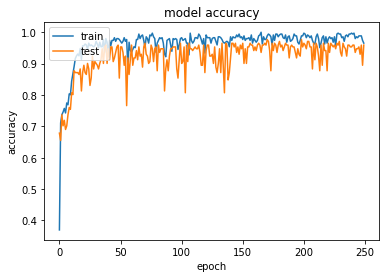

In [31]:
# summarize history for accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

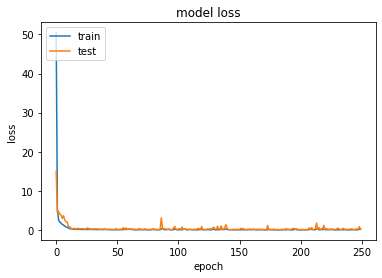

In [32]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Learning rate and drop out rate

In [58]:
from keras.layers import Dropout

# Defining the model

def create_model(learning_rate, dropout_rate):
    model = Sequential()
    model.add(Dense(11,input_dim = 11,kernel_initializer = 'normal',activation = 'relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(14,input_dim = 11,kernel_initializer = 'normal',activation = 'relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1,activation = 'sigmoid'))
    
    adam = adam_v2.Adam(lr = learning_rate)

    model.compile(loss = 'binary_crossentropy',
                  optimizer = adam,
                  metrics = ['accuracy'])
    
    return model

In [59]:
# Create the model
model = KerasClassifier(build_fn = create_model, verbose = 0,batch_size = 40,epochs = 50)

In [60]:
# Define the grid search parameters
learning_rate = [0.001, 0.01, 0.1]
dropout_rate = [0.0, 0.1, 0.2]

# Make a dictionary of the grid search parameters
param_grids = dict(learning_rate = learning_rate,dropout_rate = dropout_rate)

In [88]:
# Build and fit the GridSearchCV

grid = GridSearchCV(estimator = model,param_grid = param_grids,cv = KFold(),verbose = 10)
grid_result = grid.fit(X_standardized,y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START neuron1=4, neuron2=2........................................
[CV 1/5; 1/9] END .........neuron1=4, neuron2=2;, score=1.000 total time=   3.5s
[CV 2/5; 1/9] START neuron1=4, neuron2=2........................................
[CV 2/5; 1/9] END .........neuron1=4, neuron2=2;, score=0.750 total time=   3.9s
[CV 3/5; 1/9] START neuron1=4, neuron2=2........................................
[CV 3/5; 1/9] END .........neuron1=4, neuron2=2;, score=0.670 total time=   3.5s
[CV 4/5; 1/9] START neuron1=4, neuron2=2........................................
[CV 4/5; 1/9] END .........neuron1=4, neuron2=2;, score=0.748 total time=   3.5s
[CV 5/5; 1/9] START neuron1=4, neuron2=2........................................
[CV 5/5; 1/9] END .........neuron1=4, neuron2=2;, score=0.767 total time=   3.7s
[CV 1/5; 2/9] START neuron1=4, neuron2=4........................................
[CV 1/5; 2/9] END .........neuron1=4, neuron2=4;,

In [63]:
# Summarize the results
print('Best : {}, using {}'.format(grid_result.best_score_,grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print('{},{} with: {}'.format(mean, stdev, param))

Best : 0.9747759580612183, using {'dropout_rate': 0.1, 'learning_rate': 0.01}
0.8992344975471497,0.0564581361167721 with: {'dropout_rate': 0.0, 'learning_rate': 0.001}
0.959260630607605,0.044040643731910245 with: {'dropout_rate': 0.0, 'learning_rate': 0.01}
0.9553771495819092,0.03962789540102695 with: {'dropout_rate': 0.0, 'learning_rate': 0.1}
0.8722180843353271,0.06365578555920609 with: {'dropout_rate': 0.1, 'learning_rate': 0.001}
0.9747759580612183,0.025029280078353495 with: {'dropout_rate': 0.1, 'learning_rate': 0.01}
0.9379574298858643,0.036671916564909625 with: {'dropout_rate': 0.1, 'learning_rate': 0.1}
0.8625466823577881,0.07785605714373946 with: {'dropout_rate': 0.2, 'learning_rate': 0.001}
0.9747759580612183,0.01802316597912194 with: {'dropout_rate': 0.2, 'learning_rate': 0.01}
0.9380881309509277,0.03977464282479281 with: {'dropout_rate': 0.2, 'learning_rate': 0.1}


# Activation Function and Kernel Initializer

In [64]:
# Defining the model

def create_model(activation_function,init):
    model = Sequential()
    model.add(Dense(11,input_dim = 11,kernel_initializer = init,activation = activation_function))
    model.add(Dropout(0.2))
    model.add(Dense(14,input_dim = 11,kernel_initializer = init,activation = activation_function))
    model.add(Dropout(0.2))
    model.add(Dense(1,activation = 'sigmoid'))
    
    adam = adam_v2.Adam(lr = 0.001)
    model.compile(loss = 'binary_crossentropy',optimizer = adam,metrics = ['accuracy'])
    return model

In [65]:
# Create the model
model = KerasClassifier(build_fn = create_model,verbose = 0,batch_size = 40,epochs = 50)

In [66]:
# Define the grid search parameters
activation_function = ['softmax', 'relu', 'tanh', 'linear']
init = ['uniform', 'normal', 'zero']

# Make a dictionary of the grid search parameters
param_grids = dict(activation_function = activation_function,init = init)

In [67]:
a = StandardScaler()
a.fit(x)
X_standardized = a.transform(x)

In [68]:
# Build and fit the GridSearchCV
grid = GridSearchCV(estimator = model, param_grid = param_grids,cv = KFold(),verbose = 10)
grid_result = grid.fit(X_standardized,y)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5; 1/12] START activation_function=softmax, init=uniform..................
[CV 1/5; 1/12] END activation_function=softmax, init=uniform;, score=1.000 total time=   1.7s
[CV 2/5; 1/12] START activation_function=softmax, init=uniform..................
[CV 2/5; 1/12] END activation_function=softmax, init=uniform;, score=0.750 total time=   1.4s
[CV 3/5; 1/12] START activation_function=softmax, init=uniform..................
[CV 3/5; 1/12] END activation_function=softmax, init=uniform;, score=0.524 total time=   1.6s
[CV 4/5; 1/12] START activation_function=softmax, init=uniform..................
[CV 4/5; 1/12] END activation_function=softmax, init=uniform;, score=0.680 total time=   1.8s
[CV 5/5; 1/12] START activation_function=softmax, init=uniform..................
[CV 5/5; 1/12] END activation_function=softmax, init=uniform;, score=0.699 total time=   1.4s
[CV 1/5; 2/12] START activation_function=softmax, init=normal...

[CV 3/5; 10/12] END activation_function=linear, init=uniform;, score=0.932 total time=   1.2s
[CV 4/5; 10/12] START activation_function=linear, init=uniform..................
[CV 4/5; 10/12] END activation_function=linear, init=uniform;, score=0.903 total time=   1.2s
[CV 5/5; 10/12] START activation_function=linear, init=uniform..................
[CV 5/5; 10/12] END activation_function=linear, init=uniform;, score=0.903 total time=   1.3s
[CV 1/5; 11/12] START activation_function=linear, init=normal...................
[CV 1/5; 11/12] END activation_function=linear, init=normal;, score=1.000 total time=   1.8s
[CV 2/5; 11/12] START activation_function=linear, init=normal...................
[CV 2/5; 11/12] END activation_function=linear, init=normal;, score=0.865 total time=   1.4s
[CV 3/5; 11/12] START activation_function=linear, init=normal...................
[CV 3/5; 11/12] END activation_function=linear, init=normal;, score=0.893 total time=   1.6s
[CV 4/5; 11/12] START activation_f

In [69]:

# Summarize the results
print('Best : {}, using {}'.format(grid_result.best_score_,grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
  print('{},{} with: {}'.format(mean, stdev, param))

Best : 0.9302651286125183, using {'activation_function': 'linear', 'init': 'uniform'}
0.7305825233459473,0.15435061319000673 with: {'activation_function': 'softmax', 'init': 'uniform'}
0.7305825233459473,0.15435061319000673 with: {'activation_function': 'softmax', 'init': 'normal'}
0.7305825233459473,0.15435061319000673 with: {'activation_function': 'softmax', 'init': 'zero'}
0.8216952919960022,0.15949316403473465 with: {'activation_function': 'relu', 'init': 'uniform'}
0.8392457127571106,0.08887087662740312 with: {'activation_function': 'relu', 'init': 'normal'}
0.7305825233459473,0.15435061319000673 with: {'activation_function': 'relu', 'init': 'zero'}
0.9264003038406372,0.03997026226748417 with: {'activation_function': 'tanh', 'init': 'uniform'}
0.9186519861221314,0.04179472091685538 with: {'activation_function': 'tanh', 'init': 'normal'}
0.7305825233459473,0.15435061319000673 with: {'activation_function': 'tanh', 'init': 'zero'}
0.9302651286125183,0.03645484297710894 with: {'activa

# Number of Neurons in activation layer

In [70]:
# Defining the model

def create_model(neuron1,neuron2):
    model = Sequential()
    model.add(Dense(neuron1,input_dim = 11,kernel_initializer = 'uniform',activation = 'linear'))
    model.add(Dropout(0.2))
    model.add(Dense(neuron2,input_dim = neuron1,kernel_initializer = 'uniform',activation = 'linear'))
    model.add(Dropout(0.2))
    model.add(Dense(1,activation = 'sigmoid'))
    
    adam = adam_v2.Adam(lr = 0.001)
    model.compile(loss = 'binary_crossentropy',
                  optimizer = adam,
                  metrics = ['accuracy'])
    return model

In [71]:
# Create the model

model = KerasClassifier(build_fn = create_model,
                        verbose = 0,
                        batch_size = 40,
                        epochs = 50)

In [72]:
# Define the grid search parameters

neuron1 = [4,8,16]
neuron2 = [2,4,8]

# Make a dictionary of the grid search parameters

param_grids = dict(neuron1 = neuron1,
                   neuron2 = neuron2)

In [74]:
# Build and fit the GridSearchCV

grid = GridSearchCV(estimator = model,
                    param_grid = param_grids,
                    cv = KFold(),
                    verbose = 10)

grid_result = grid.fit(X_standardized,y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START neuron1=4, neuron2=2........................................
[CV 1/5; 1/9] END .........neuron1=4, neuron2=2;, score=1.000 total time=   1.2s
[CV 2/5; 1/9] START neuron1=4, neuron2=2........................................
[CV 2/5; 1/9] END .........neuron1=4, neuron2=2;, score=0.750 total time=   1.2s
[CV 3/5; 1/9] START neuron1=4, neuron2=2........................................
[CV 3/5; 1/9] END .........neuron1=4, neuron2=2;, score=0.670 total time=   1.2s
[CV 4/5; 1/9] START neuron1=4, neuron2=2........................................
[CV 4/5; 1/9] END .........neuron1=4, neuron2=2;, score=0.738 total time=   1.1s
[CV 5/5; 1/9] START neuron1=4, neuron2=2........................................
[CV 5/5; 1/9] END .........neuron1=4, neuron2=2;, score=0.825 total time=   1.5s
[CV 1/5; 2/9] START neuron1=4, neuron2=4........................................
[CV 1/5; 2/9] END .........neuron1=4, neuron2=4;,

In [75]:
# Summarize the results
print('Best : {}, using {}'.format(grid_result.best_score_,grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
  print('{},{} with: {}'.format(mean, stdev, param))

Best : 0.9128453969955445, using {'neuron1': 16, 'neuron2': 8}
0.796601939201355,0.11301821329168882 with: {'neuron1': 4, 'neuron2': 2}
0.8082524299621582,0.10217264118124691 with: {'neuron1': 4, 'neuron2': 4}
0.8296116471290589,0.08930455638866369 with: {'neuron1': 4, 'neuron2': 8}
0.812135910987854,0.10670340831193455 with: {'neuron1': 8, 'neuron2': 2}
0.8412248015403747,0.08212179085237079 with: {'neuron1': 8, 'neuron2': 4}
0.8818708062171936,0.060045562857774175 with: {'neuron1': 8, 'neuron2': 8}
0.8606049418449402,0.07343045838380186 with: {'neuron1': 16, 'neuron2': 2}
0.8877333879470826,0.06117626755461539 with: {'neuron1': 16, 'neuron2': 4}
0.9128453969955445,0.04413331374983547 with: {'neuron1': 16, 'neuron2': 8}


# Number of Neurons in activation layer

In [87]:
 #Defining the model

def create_model(neuron1,neuron2):
    model = Sequential()
    model.add(Dense(neuron1,input_dim = 11,kernel_initializer = 'uniform',activation = 'linear'))
    model.add(Dropout(0.2))
    model.add(Dense(neuron2,input_dim = neuron1,kernel_initializer = 'uniform',activation = 'linear'))
    model.add(Dropout(0.2))
    model.add(Dense(1,activation = 'sigmoid'))
    
    adam = adam_v2.Adam(lr = 0.001)
    model.compile(loss = 'binary_crossentropy',optimizer = adam,metrics = ['accuracy'])
    return model

In [82]:
# Create the model
model = KerasClassifier(build_fn = create_model, verbose = 0,batch_size = 40,epochs = 50)

In [83]:
# Define the grid search parameters
neuron1 = [4,8,16]
neuron2 = [2,4,8]

# Make a dictionary of the grid search parameters
param_grids = dict(neuron1 = neuron1,neuron2 = neuron2)

In [85]:
# Build and fit the GridSearchCV

grid = GridSearchCV(estimator = model,param_grid = param_grids,cv = KFold(),verbose = 10)
grid_result = grid.fit(X_standardized,y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START neuron1=4, neuron2=2........................................
[CV 1/5; 1/9] END .........neuron1=4, neuron2=2;, score=1.000 total time=   3.8s
[CV 2/5; 1/9] START neuron1=4, neuron2=2........................................
[CV 2/5; 1/9] END .........neuron1=4, neuron2=2;, score=0.750 total time=   3.5s
[CV 3/5; 1/9] START neuron1=4, neuron2=2........................................
[CV 3/5; 1/9] END .........neuron1=4, neuron2=2;, score=0.660 total time=   4.2s
[CV 4/5; 1/9] START neuron1=4, neuron2=2........................................
[CV 4/5; 1/9] END .........neuron1=4, neuron2=2;, score=0.748 total time=   3.8s
[CV 5/5; 1/9] START neuron1=4, neuron2=2........................................
[CV 5/5; 1/9] END .........neuron1=4, neuron2=2;, score=0.796 total time=   3.7s
[CV 1/5; 2/9] START neuron1=4, neuron2=4........................................
[CV 1/5; 2/9] END .........neuron1=4, neuron2=4;,

In [86]:
# Summarize the results
print('Best : {}, using {}'.format(grid_result.best_score_,grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
  print('{},{} with: {}'.format(mean, stdev, param))

Best : 0.9205750465393067, using {'neuron1': 16, 'neuron2': 8}
0.7907767057418823,0.11347600277863003 with: {'neuron1': 4, 'neuron2': 2}
0.812135910987854,0.09938542909031652 with: {'neuron1': 4, 'neuron2': 4}
0.8257281541824341,0.09231472770037459 with: {'neuron1': 4, 'neuron2': 8}
0.8218446612358093,0.09163834920328304 with: {'neuron1': 8, 'neuron2': 2}
0.8567401170730591,0.07560510186600228 with: {'neuron1': 8, 'neuron2': 4}
0.8761015653610229,0.06499206120814136 with: {'neuron1': 8, 'neuron2': 8}
0.8664301872253418,0.07072953775436296 with: {'neuron1': 16, 'neuron2': 2}
0.8800037264823913,0.0660992581129816 with: {'neuron1': 16, 'neuron2': 4}
0.9205750465393067,0.041750114411771615 with: {'neuron1': 16, 'neuron2': 8}
